<a href="https://colab.research.google.com/github/Hussien-Sayed/GPS-Location-Correction/blob/main/new_05_02_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The data for this competition comes from two devices: a source device (with errors and missing data) and a benchmark device (that takes much more accurate readinds we'd like to match).

In this notebook, we'll load in the source data and the targets, come up with the most basic way we can think of to implement a solution.

# Loading and viewing the data



The first step is to load the data. The test data takes the form of sequences with ~120 seconds worth of readings from the source device. The training data looks similar but we're also given a corresponding target for each sequence.

Let's get a list of sequences and a list of the coresponding targets, and set up some convenience functions to view them and start to get a feel for the data:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/zindi/1.Egy_moja_Hack/UmojaHackEgypt.zip ./

In [ ]:
!unzip -P qkptu -q UmojaHackEgypt.zip
%cd UHEgypt
!cp /content/drive/MyDrive/zindi/1.Egy_moja_Hack/train_tracks.zip ./
!unzip -q train_sequences.zip
!unzip -q test_sequences.zip
!unzip -q train_targets.zip
!unzip -q train_tracks.zip

!pip install traces
!pip install catboost==1.0.4

/content/UHEgypt
  Preparing metadata (setup.py) ... done
  Created wheel for infinity: filename=infinity-1.5-py3-none-any.whl size=3090 sha256=106f4bfee37c9eaa407b4a5e9dc97b7f12e93abdc634fb7382e51b638417a7f0
  Stored in directory: /root/.cache/pip/wheels/cb/ba/c7/89592ec56d0923ca07b295d3cf21650e5de21a53cce64f87f9
Successfully built infinity
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import glob, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupShuffleSplit,KFold
from sklearn.multioutput import MultiOutputRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import traces
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Get the train input sequences
sequences = sorted(glob.glob('train_sequences/*source.csv'))
sequences[:3]

['train_sequences/track16_seq0_source.csv',
 'train_sequences/track16_seq10_source.csv',
 'train_sequences/track16_seq11_source.csv']

In [ ]:
# And their corresponding outputs
targets = [s.replace('sequence', 'target').replace('source', 'target') for s in sequences]
targets[:3]

['train_targets/track16_seq0_target.csv',
 'train_targets/track16_seq10_target.csv',
 'train_targets/track16_seq11_target.csv']

In [ ]:
# Load a sequence and return source and target dataframes
def load_seq(i):
    source = pd.read_csv(sequences[i])
    target = pd.read_csv(targets[i])
    return source, target

In [ ]:
# Example:
source, target = load_seq(0)
source.head(3)

,Time,Latitude,Longitude,Movement_Type,Accuracy
0,0.000,-0.001460,0.000430,2,16.464001
1,1.000,-0.001431,0.000429,2,16.521999
2,2.034,-0.001336,0.000439,2,16.827999


Source has some extra data - Movement Type and GPS accuracy.

In [ ]:
# And the target
target.head(3)

,Time,Latitude,Longitude
0,0,-0.001519,0.000400
1,1,-0.001483,0.000405
2,2,-0.001444,0.000407


Just looking at the data doesn't tell us much - let's plot the two together and see what this looks like.

In [ ]:
# View a sequence
def plot_seq(source, target):
    min_x, max_x, min_y, max_y = target.Longitude.min(), target.Longitude.max(), target.Latitude.min(), target.Latitude.max()
    ax = target.plot(x='Longitude', y='Latitude', c='red', label='Benchmark track',
                ylim=(min_y-0.0004, max_y+0.0004), xlim=(min_x-0.0004, max_x+0.0004), alpha=0 ) # Extra margin
    source.plot(x='Longitude', y='Latitude', c='red', kind='scatter', label='Source (input)', ax=ax, alpha=0.5)

    target.plot(x='Longitude', y='Latitude', c='blue', label='Target', ax=ax, kind='scatter', alpha=0.3)
    return ax

515


<Axes: xlabel='Longitude', ylabel='Latitude'>

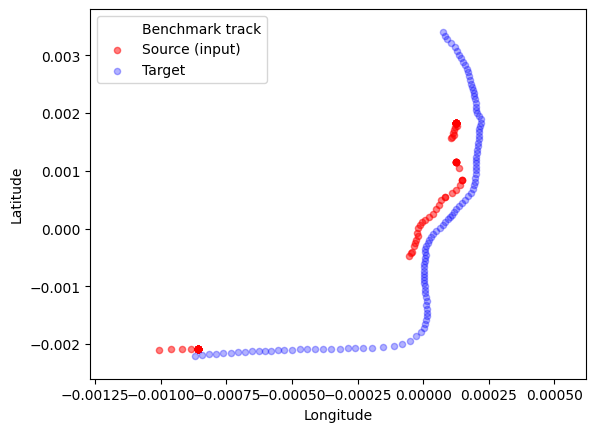

In [ ]:
# Load and view a random example
n = random.randint(0, len(sequences))
print(n)
source, target = load_seq(n)
plot_seq(source, target)

In [ ]:
source.drop_duplicates(subset='Latitude')

,Time,Latitude,Longitude,Movement_Type,Accuracy
0,0.000,-0.002100,-0.001007,2,19.125000
1,0.999,-0.002092,-0.000961,2,19.139000
2,2.002,-0.002093,-0.000921,2,19.349001
3,2.997,-0.002085,-0.000885,2,19.351000
4,3.999,-0.002076,-0.000859,2,19.794001
50,49.998,-0.000469,-0.000052,2,19.723000
51,50.995,-0.000421,-0.000047,2,19.212999
52,51.999,-0.000412,-0.000043,2,18.552000
53,53.002,-0.000307,-0.000034,2,18.069000
54,53.998,-0.000252,-0.000032,2,18.132999


In [ ]:
abs(source.Time.values - source.index.values).max()

0.028999999999996362

# Understanding the problem

So, what makes this hard? Run the cell above a few times and you'll see that we have two main challenges:
- There are gaps in the source data - places where the GPS location is repeated again and again with no updates. This corresponds to a loss of GPS signal in the device
- There accuracy isn't that great even when locations are reported. The source device tries its best but the GPS isn't very accurate compared to the benchmark device. You can actually inspect the estimated GPS accuracy reported by the source device by looking at the Accuracy column.

When we drop rows with duplicate locations, we can see how much data is missing. Let's look at a specific example which we'll then use to come up with our first solution:

In [ ]:
source, target = load_seq(247)
source.shape, source.drop_duplicates(subset='Latitude').shape

((120, 5), (67, 5))

<Axes: xlabel='Longitude', ylabel='Latitude'>

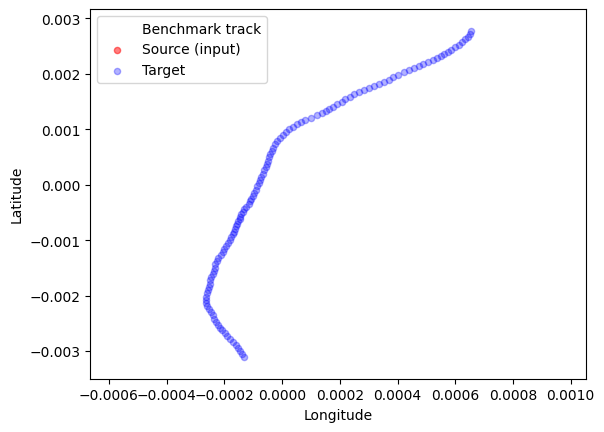

In [ ]:
plot_seq(source, target)

Notice the gap in the middle... We only have 67 readings once we remove duplicates! Let's try to fix that by filling in some sensible values.

# A Minimal Solution

Before we even look at learning-based solutions, let's try some simple interpolation. If we ignore repeat locations and instead try to fill in the data with linear interpolation based on the points we do have, won't that get us pretty close?

Here I'm using the traces library to treat the Latitude and Longitude columns as two independant timeseries, which we can re-sample to the nice, neat 1-second interval we need to match the target:

<Axes: xlabel='Longitude', ylabel='Latitude'>

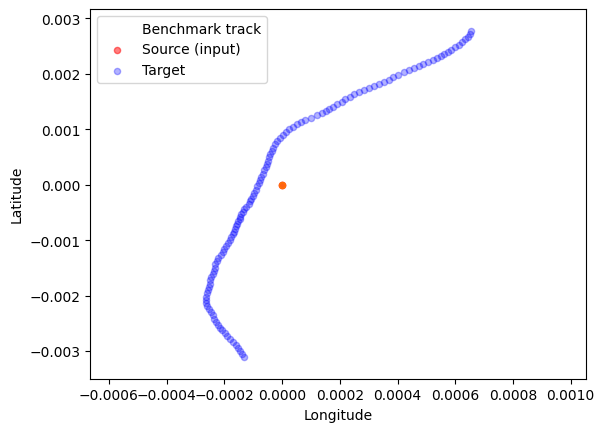

In [ ]:
def smooth(source):

    # Create a dataframe to store our predictions
    preds = pd.DataFrame({
        'Time':range(120)
    })
    original_sub = source.copy()

    # Drop duplicates from the source (places where GPS is lost)
    source = source.drop_duplicates(subset='Latitude')

    # Create traces timeseries for both Latitude and Longitude
    lat_ts = traces.TimeSeries([s for s in source[['Time', 'Latitude']].values])
    lon_ts = traces.TimeSeries([s for s in source[['Time', 'Longitude']].values])

    # Resample with linear interpolation and store results
    preds['Latitude'] = [x[1] for x in lat_ts.sample(sampling_period=1,interpolate='linear', start=0, end=119)]
    preds['Longitude'] = [x[1] for x in lon_ts.sample(sampling_period=1,interpolate='linear', start=0, end=119)]

    preds['Accuracy'] = original_sub['Accuracy']
    preds['Movement_Type'] = original_sub['Movement_Type']

    # Return the predictions
    return preds

# Plot the result when we apply this to our sequence
ax = plot_seq(source, target)
preds = smooth(source)
preds.plot(x='Longitude', y='Latitude', kind='scatter', c='yellow', ax=ax, alpha=0.3)

We've filled in the gap pretty well. And we didn't need to do any modelling! Let's use this to set up our testing and submission strategy.

# Better Interpolation

<Axes: xlabel='Longitude', ylabel='Latitude'>

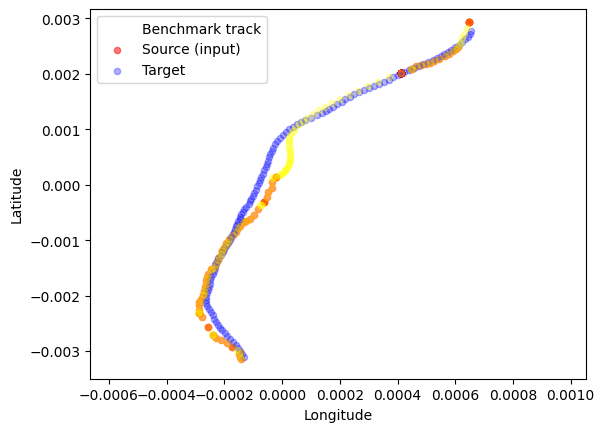

In [ ]:
def smooth(source):

    # Create a dataframe to store our predictions
    preds = pd.DataFrame({
        'Time':range(120)
    })
    original_sub = source.copy()
    ix = original_sub.duplicated(subset='Latitude')
    preds = original_sub[['Latitude','Longitude']].copy()
    preds[ix] = np.nan
    preds = preds.interpolate(method='quadratic')
    if preds.isna().any().any():
      preds = preds.interpolate(method='linear')
    # Drop duplicates from the source (places where GPS is lost)
    #source = source.drop_duplicates(subset='Latitude')

    # Create traces timeseries for both Latitude and Longitude
    #lat_ts = traces.TimeSeries([s for s in source[['Time', 'Latitude']].values])
    #lon_ts = traces.TimeSeries([s for s in source[['Time', 'Longitude']].values])

    # Resample with linear interpolation and store results
    #preds['Latitude'] = [x[1] for x in lat_ts.sample(sampling_period=1,interpolate='linear', start=0, end=119)]
    #preds['Longitude'] = [x[1] for x in lon_ts.sample(sampling_period=1,interpolate='linear', start=0, end=119)]

    preds['Accuracy'] = original_sub['Accuracy']
    preds['Movement_Type'] = original_sub['Movement_Type']

    # Return the predictions
    return preds

# Plot the result when we apply this to our sequence
ax = plot_seq(source, target)
preds = smooth(source)
preds.plot(x='Longitude', y='Latitude', kind='scatter', c='yellow', ax=ax, alpha=0.3)

<Axes: xlabel='Longitude', ylabel='Latitude'>

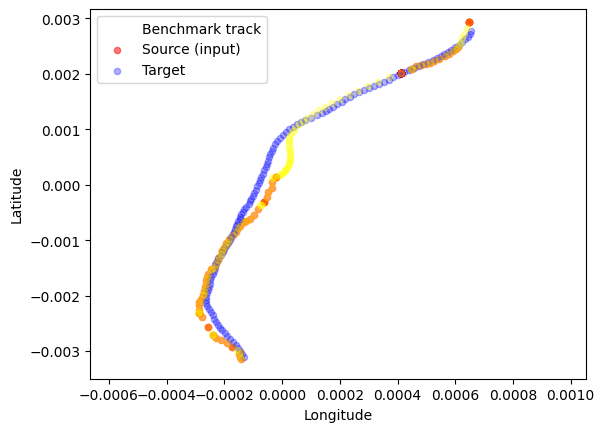

In [ ]:
ix = source.duplicated(subset='Latitude')
preds = source[['Latitude','Longitude']].copy()
preds[ix] = np.nan
preds =preds.interpolate(method='polynomial',order=2)
#preds2 = f.fit_transform(preds)
#preds[['Latitude','Longitude']] = preds2
ax = plot_seq(source, target)
preds.plot(x='Longitude', y='Latitude', kind='scatter', c='yellow', ax=ax, alpha=0.3)

# Metrics and Submission

The competition uses RMSE and requires predictions in a specific format. Let's first replicate the scoring and then make a submission file to see how well we do on the leaderboard.

In [ ]:
# Scoring a our preds vs the target for this sequence
mean_squared_error(target[['Latitude', 'Longitude']], preds[['Latitude', 'Longitude']], squared=False)

6.3822264116194e-05

In [ ]:
# Making predictions for all sequences and combining all targets:
all_targets = pd.concat([load_seq(i)[1] for i in range(len(sequences))])
all_preds = pd.concat([smooth(load_seq(i)[0]) for i in range(len(sequences))])

# Scoring function
def score(targets, preds):
    return np.sqrt(mean_squared_error(targets[['Latitude', 'Longitude']], preds[['Latitude', 'Longitude']]))

# Show our score
score(all_targets, all_preds)

0.0003553909051712651

In [ ]:
for i in range(len(sequences)):
   if load_seq(i)[0].isna().sum().all()!=0:
     print(i)

There are many different ways you could implement the above code, but this is good enough to give us a score. Next we need to turn our predictions into the right format. Let's load in the sample submission and get to work:

In [ ]:
ss = pd.read_csv('SampleSubmission.csv')
ss.head()

,Row_ID,Prediction
0,SEQ_AKvyOXIS X time0 X Latitude,0
1,SEQ_AKvyOXIS X time0 X Longitude,0
2,SEQ_AKvyOXIS X time1 X Latitude,0
3,SEQ_AKvyOXIS X time1 X Longitude,0
4,SEQ_AKvyOXIS X time10 X Latitude,0


We need one row for each sequence for each time for each column (lat and lon). For conveneince, let's add some extra columns to make life easier:

In [ ]:
# Adding extra columns to ss
ss['Seq_ID'] = ss['Row_ID'].apply(lambda s: s.split(' X ')[0])
ss['Time'] = ss['Row_ID'].apply(lambda s: s.split(' X ')[1][4:])
ss['Col'] = ss['Row_ID'].apply(lambda s: s.split(' X ')[2])
ss.sample(3)

,Row_ID,Prediction,Seq_ID,Time,Col
53543,SEQ_bWQgBztF X time108 X Longitude,0,SEQ_bWQgBztF,108,Longitude
2360,SEQ_AvukdAAo X time81 X Latitude,0,SEQ_AvukdAAo,81,Latitude
98195,SEQ_wcNZOJcV X time113 X Longitude,0,SEQ_wcNZOJcV,113,Longitude


Now we can iterate through the test sequences, making predictions for each one with our 'smooth' function and writing the data to the ss dataframe.

If you're careful with the ordering you can avoid those time-consuming `.loc` lines and write the predictions in one go, but this way is nice and explicit and it doesn't take too long.

In [ ]:
seq_ids = ss['Seq_ID'].unique() # The sequences we need to make predictions on
print('Seq IDs:', seq_ids[:3], '...') # Print examples

# Going through the sequences one by one
for seq_id in seq_ids:

    # Load the source data
    source = pd.read_csv(f'test_sequences/{seq_id}_source.csv')

    # Make predictions
    preds = smooth(source)

    # Write the predictions to the right place in ss
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Latitude'), 'Prediction'] = preds['Latitude'].values
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Longitude'), 'Prediction'] = preds['Longitude'].values

# Check that we now have data in our 'Prediction' column
ss.sample(5)

Seq IDs: ['SEQ_AKvyOXIS' 'SEQ_ATrnElYt' 'SEQ_AXRDVgEw'] ...


,Row_ID,Prediction,Seq_ID,Time,Col
7421,SEQ_DwtfZkEe X time90 X Longitude,0.001165,SEQ_DwtfZkEe,90,Longitude
6965,SEQ_DhfRiXxp X time10 X Longitude,0.001240,SEQ_DhfRiXxp,10,Longitude
79198,SEQ_oskEsZoW X time99 X Latitude,-0.000530,SEQ_oskEsZoW,99,Latitude
27470,SEQ_ODxVWNav X time40 X Latitude,0.000467,SEQ_ODxVWNav,40,Latitude
106483,SEQ_zwbmkylm X time64 X Longitude,0.000668,SEQ_zwbmkylm,64,Longitude


In [ ]:
# Save our predictions
ss[['Row_ID', 'Prediction']].to_csv('baseline.csv', index=False)

This submission file can be uploaded on Zindi for a score. The test set comes from a different set of tracks, so your scores might be different on the leaderboard when compared to local scoring, but the local score let's you pick your best strategies before using a submission on Zindi.

Now that we have a first solution in, let's look at the data more closely and brainstorm some ways of improving our performance.

# Applying machine learning

In this section, we'll apply machine learning instead of simple interpolation and see the difference. Fistly, we'll load all data in matrix format. Secondly, we will split the data into training and validation. Thirdly, we'll train a model on the training data and check the error on the validation data. Finally, we'll maka a submission using our model.

## Read all data

Each track (for source and target) has 120 timestamp and each timestamp has 4 attributes (if we ignore time). So, we'll create a feature vector for each track with 120 X 4 = 480 features. Our goal will predicting the target's 240 value (120 langitude and 120 latitude).

In [ ]:
all_source_data = []
all_target_data = []
key_features = ['Latitude', 'Longitude', 'Movement_Type', 'Accuracy']

for i in range(len(sequences)):
    print(i)
    source, target = load_seq(i)
    if source.shape[0] != 120:
        print(i)
    source = smooth(source)
    print('Data shape before vectorization: ', source[key_features].shape, target[key_features[:2]].shape)
    source_feat_flatten = source[key_features].values.flatten().reshape(1, -1)
    target_flatten = target[key_features[:2]].values.flatten().reshape(1, -1)
    print('Data shape after vectorization: ', source_feat_flatten.shape, target_flatten.shape)
    all_source_data.append(source_feat_flatten)
    all_target_data.append(target_flatten)

all_source_data = np.concatenate(all_source_data, 0)
all_target_data = np.concatenate(all_target_data, 0)
print('Final all data shape', all_source_data.shape, all_target_data.shape)

0
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
1
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
2
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
3
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
4
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
5
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
6
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
7
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
8
Data shape before vectorization:  (120, 4) (120, 2)
Data shape after vectorization:  (1, 480) (1, 240)
9
Data shape before vectorization:  (120, 4) (120, 2)
D

## Data splitting

We want to split the data into training and validation as we have limited number of submissions in the hackathon and we need to have a way of evaluating our model before submission. Having a held out validation set will help achieve that. The most important aspect is to split the data so that validation is completely unseen to the model in order to have a proper evaluation. Therefore, we will split the data by the original track number so that no track has no data in both training and validation.

In [ ]:
source_files = glob.glob('train_sequences/*source.csv')
track_numbers = [int(s.split('track')[-1].split('_')[0]) for s in source_files]

gss = GroupShuffleSplit(n_splits=2, train_size=.7, random_state=42)
#split the data so that a track number doesn't occur at training and validation in the sametime
for train_index, val_index in gss.split(all_source_data, all_target_data, track_numbers):
    train_source_data, val_source_data = all_source_data[train_index], all_source_data[val_index]
    train_target_data, val_target_data = all_target_data[train_index], all_target_data[val_index]
    print('Training data size: ', train_source_data.shape, train_target_data.shape)
    print('Validation data size: ', val_source_data.shape, val_target_data.shape)
    break

Training data size:  (389, 480) (389, 240)
Validation data size:  (164, 480) (164, 240)


## Train and evaluate a machine learning model
Now we will train a machine learning called gradient boosting machine which is a variant of decision tree model. Since we need to predict 240 numerical value per sample (track), we need to train a multi-output regression model.

In [ ]:
# Fit a model and predict the lens values from the original features
model = XGBRegressor(random_state=0)
model = MultiOutputRegressor(model)
model.fit(train_source_data, train_target_data)

val_preds = model.predict(val_source_data)
val_error = np.sqrt(mean_squared_error(val_target_data, val_preds))
print('validation error: ', val_error)

validation error:  0.00015669998892003484


In [ ]:
# Ordering by Time to keep row order consistent <<<<< Fix for initial error
ss['Time'] = ss['Time'].astype(int)
ss = ss.sort_values(by='Time')

seq_ids = ss['Seq_ID'].unique() # The sequences we need to make predictions on
print('Seq IDs:', seq_ids[:3], '...') # Print examples

# Going through the sequences one by one
for seq_id in seq_ids:

    # Load the source data
    source = pd.read_csv(f'test_sequences/{seq_id}_source.csv')

    # Make predictions
    source = smooth(source)
    source_feat_flatten = source[key_features].values.flatten().reshape(1, -1)
    preds = model.predict(source_feat_flatten)
    preds = preds.reshape(source.shape[0], 2)


    # Write the predictions to the right place in ss
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Latitude'), 'Prediction'] = preds[:,0]
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Longitude'), 'Prediction'] = preds[:,1]

# Save our predictions
ss[['Row_ID', 'Prediction']].to_csv('XB.csv', index=False)

Seq IDs: ['SEQ_AKvyOXIS' 'SEQ_mrGTzHGM' 'SEQ_tICBnHQa'] ...


(164, 120, 2)


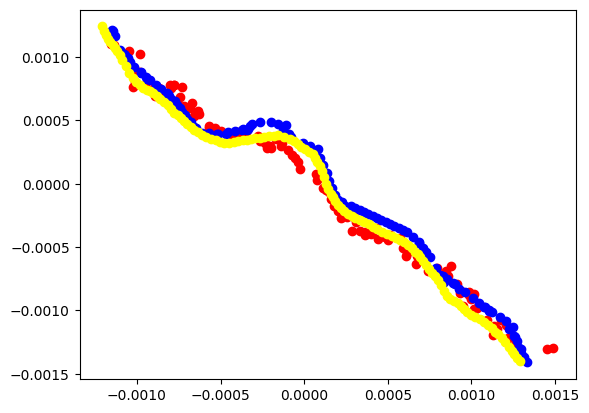

In [ ]:
#plot a sample
preds = val_preds.reshape(val_source_data.shape[0],-1, 2)
vals_s =val_source_data.reshape(val_source_data.shape[0],-1, 4)
vals_t =val_target_data.reshape(val_source_data.shape[0],-1, 2)
print(preds.shape)
n = random.randint(0, vals_s.shape[0])
plt.scatter(preds[n,:,0],preds[n,:,1],c="red")
plt.scatter(vals_s[n,:,0],vals_s[n,:,1],c="blue")
plt.scatter(vals_t[n,:,0],vals_t[n,:,1],c="yellow")

We can see that our score with machine learning is better than just simple smoothing.

## LB train

In [ ]:
model = LGBMRegressor()
model = MultiOutputRegressor(model)
model.fit(train_source_data, train_target_data)

val_preds = model.predict(val_source_data)
val_error = np.sqrt(mean_squared_error(val_target_data, val_preds))
print(val_error)



Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
# Ordering by Time to keep row order consistent <<<<< Fix for initial error
ss['Time'] = ss['Time'].astype(int)
ss = ss.sort_values(by='Time')

seq_ids = ss['Seq_ID'].unique() # The sequences we need to make predictions on
print('Seq IDs:', seq_ids[:3], '...') # Print examples

# Going through the sequences one by one
for seq_id in seq_ids:

    # Load the source data
    source = pd.read_csv(f'test_sequences/{seq_id}_source.csv')

    # Make predictions
    source = smooth(source)
    source_feat_flatten = source[key_features].values.flatten().reshape(1, -1)
    preds = model.predict(source_feat_flatten)
    preds = preds.reshape(source.shape[0], 2)


    # Write the predictions to the right place in ss
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Latitude'), 'Prediction'] = preds[:,0]
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Longitude'), 'Prediction'] = preds[:,1]

# Check that we now have data in our 'Prediction' column
ss.sample(5)

Seq IDs: ['SEQ_AKvyOXIS' 'SEQ_pHezdhdu' 'SEQ_amlGBtdG'] ...


,Row_ID,Prediction,Seq_ID,Time,Col
95261,SEQ_vZzCeZjl X time90 X Longitude,-0.000224,SEQ_vZzCeZjl,90,Longitude
45804,SEQ_XuzexlYj X time83 X Latitude,-0.001047,SEQ_XuzexlYj,83,Latitude
27254,SEQ_NwOnTjXn X time51 X Latitude,0.000099,SEQ_NwOnTjXn,51,Latitude
42911,SEQ_WODIudjC X time77 X Longitude,0.000057,SEQ_WODIudjC,77,Longitude
47190,SEQ_YpqItHow X time59 X Latitude,-0.000033,SEQ_YpqItHow,59,Latitude


In [ ]:
# Save our predictions
ss[['Row_ID', 'Prediction']].to_csv('LB.csv', index=False)

## Make a submission

In [ ]:
# Ordering by Time to keep row order consistent <<<<< Fix for initial error
ss['Time'] = ss['Time'].astype(int)
ss = ss.sort_values(by='Time')

seq_ids = ss['Seq_ID'].unique() # The sequences we need to make predictions on
print('Seq IDs:', seq_ids[:3], '...') # Print examples

# Going through the sequences one by one
for seq_id in seq_ids:

    # Load the source data
    source = pd.read_csv(f'test_sequences/{seq_id}_source.csv')

    # Make predictions
    source = smooth(source)
    source_feat_flatten = source[key_features].values.flatten().reshape(1, -1)
    preds = model.predict(source_feat_flatten)
    preds = preds.reshape(source.shape[0], 2)


    # Write the predictions to the right place in ss
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Latitude'), 'Prediction'] = preds[:,0]
    ss.loc[(ss.Seq_ID == seq_id)&(ss.Col=='Longitude'), 'Prediction'] = preds[:,1]

# Check that we now have data in our 'Prediction' column
ss.sample(5)

Seq IDs: ['SEQ_AKvyOXIS' 'SEQ_pHezdhdu' 'SEQ_amlGBtdG'] ...


,Row_ID,Prediction,Seq_ID,Time,Col
44038,SEQ_XKnpisiQ X time44 X Latitude,0.000058,SEQ_XKnpisiQ,44,Latitude
8082,SEQ_EJEzzNxf X time64 X Latitude,0.000498,SEQ_EJEzzNxf,64,Latitude
8401,SEQ_EQSJfbjD X time0 X Longitude,-0.001415,SEQ_EQSJfbjD,0,Longitude
34007,SEQ_QznxLDZl X time66 X Longitude,-0.000062,SEQ_QznxLDZl,66,Longitude
23956,SEQ_Liypmurf X time8 X Latitude,-0.000534,SEQ_Liypmurf,8,Latitude


In [ ]:
# Save our predictions
ss[['Row_ID', 'Prediction']].to_csv('submission2.csv', index=False)

## Ideas for improvements
We trained a simple model and there are many interesting ideas that can be tried. For example:
* use k-fold validation for better local validation
* hyperparamter tuning
* other models: linear regression, svm , random forest
* feature engineering
* RNN models
* ensemble of models
* increase data size (follow the rest of the notebook)

# Loading the train tracks

In addition the the train sequences, which have been transformed to match those in the test set, you are also provided with the full data from the runs from which the train sequences were generated. In this section we'll make some animations and re-create the track -> sequences pipeline to see how we might augment our training data.

### Loading the tracks

In [ ]:
# Getting the track numbers in the training set
source_files = glob.glob('train_tracks/*source.csv')
train_track_numbers = [int(s.split('track')[-1].split('_')[0]) for s in source_files]
print('Train track numbers:', train_track_numbers)

# A function to load the source and benchmark data fr a given track
def load_track(track):
    source = pd.read_csv(f'train_tracks/track{track}_source.csv')
    bench = pd.read_csv(f'train_tracks/track{track}_bench.csv')
    return source, bench

# Loading an example track
source, bench = load_track(17)
print('Shapes', source.shape, bench.shape)
bench.head(2)

Train track numbers: [25, 29, 16, 17, 20, 22, 28, 27, 21, 26, 18, 19, 23, 24]
Shapes (2046, 5) (2026, 3)


,Time,Latitude,Longitude
0,2.6,59.441447,17.899972
1,3.6,59.441443,17.899937


In [ ]:
source.head(2)

,Time,Latitude,Longitude,Movement_Type,Accuracy
0,0.00,0.0,0.0,0,0.0
1,0.52,0.0,0.0,0,0.0


The benchmark has not yet been re-sampled to 1-second intervals. And both source and bench now cover a much longer time period. We can use our plot_seq() function from before with bench in place of target to see the overview, but first we need to drop any (0, 0)s from the source data.

<Axes: xlabel='Longitude', ylabel='Latitude'>

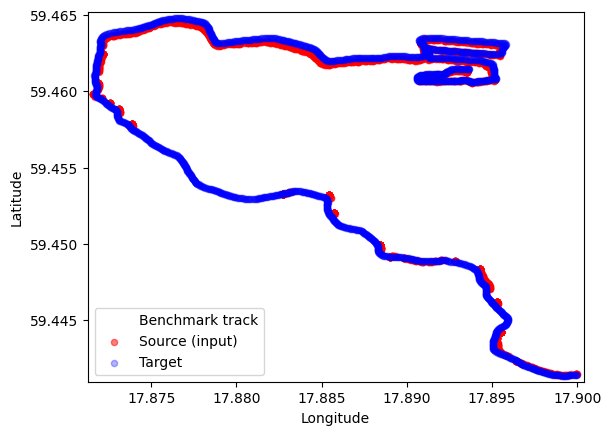

In [ ]:
source = source.loc[source.Latitude != 0]
plot_seq(source, bench)

You can see that the full track is much longer. We can split this into as many short sequences as we'd like. This static view doesn't quite tell the full story, so in this next bit of code we'll slice this up into sequences and then animate the result to get a better idea of what's going on:

### Splitting and Animating

In [ ]:
# First, a function to clip out our sequences
def gen_seq(source, bench, start, end):
    """ Splits out source[start:end] and bench[start:end] (smoothed version of bench)"""

    # Slice of the source data
    s = source[source.Time < end].copy()
    s = s[s.Time > start]

    # Slice of the benchmark track as the target
    t = bench[bench.Time < end].copy()
    t = t[t.Time > start]

    # Use our smooth function to resample. Since it sets time to (0, 120) we need to add back the start time
    #t_start = t.Time.values[0]
    #t.Time -= t_start
    #t = smooth(t)
    #t.Time += t_start

    return s, t

# And one that uses this to split a whole track into sections, moving step forward each time
def gen_sequences(source, bench, seq_length,step=30):
    """ Split source and bench into sections """
    max_t = int(bench.Time.values[-1])
    seqs = []
    for start in range(0, max_t-seq_length, step):
        seqs.append(gen_seq(source, bench, start, start+seq_length))

    return seqs

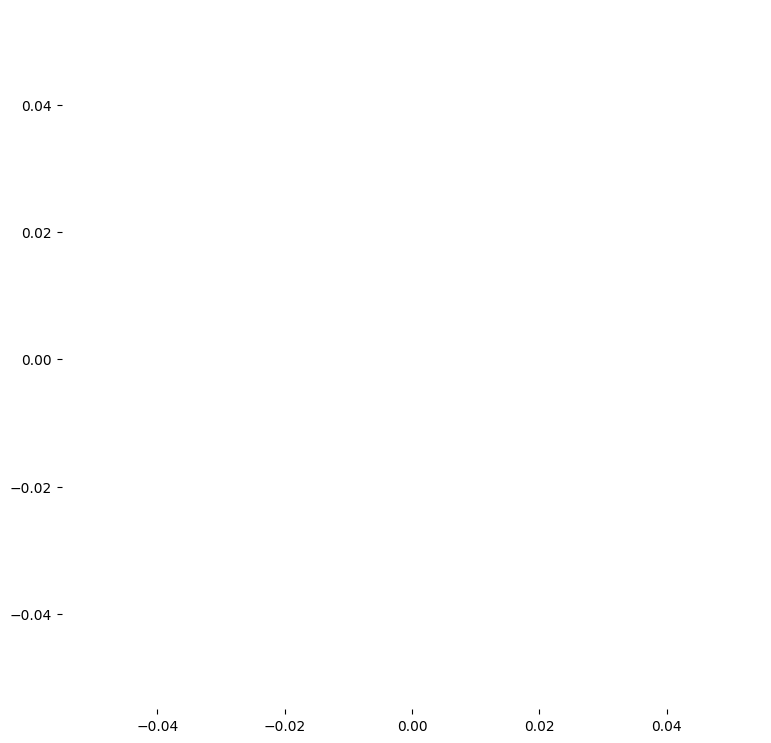

In [ ]:
# Load some data
source, bench = load_track(17)

# Split into seqs
seqs = gen_sequences(source, bench, 120, step=30)

# Create a figure to draw over. We need %matplotlib notebook to avoid crating a static plot
#%matplotlib notebook
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1], frameon=False)

# Construct the scatters which we will update during animation
#ax.plot(bench['Longitude'], bench['Latitude'], c='yellow', alpha=0.3, label='Benchmark Track')
source_scatter = ax.scatter([], [], color='green', label='Source', alpha=0.2)
target_scatter = ax.scatter([], [], color='blue', label='Target', alpha=0.1)
#plt.legend()

# This update function shows the next frame by updating the two scatter plots
def update(frame_number):
    # Source (green)
    source_data = seqs[frame_number][0][['Longitude', 'Latitude']]
    source_scatter.set_offsets(source_data)

    # Target (blue)
    target_data = seqs[frame_number][1][['Longitude', 'Latitude']]
    target_scatter.set_offsets(target_data)



# Show animation
#animation = FuncAnimation(fig, update, frames=range(len(seqs)), interval=300)
#plt.show()

Pretty cool! You can view individual sequences from our list of generates sequences with:

<Axes: xlabel='Longitude', ylabel='Latitude'>

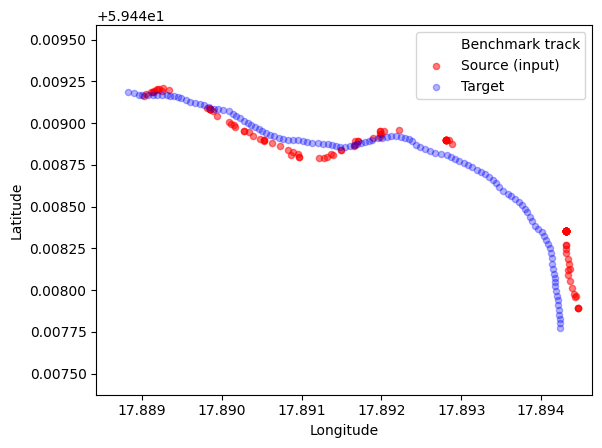

In [ ]:
source, target = seqs[10]
plot_seq(source, target)


In [ ]:
source, target = seqs[1]
source = source.drop_duplicates(subset='Latitude')
source.Time.values[-1],target.Time.values[-1]

(147.506, 149.6)

In [ ]:
is_ok_seq(seqs[3])

False

### Filtering out bad sequences

These sequences are mostly OK. However, some sequences are missing too much source data to be useful. We can filter these out with:

In [ ]:
def is_ok_seq(seq):
    source, target = seq

    # Check targets are present
    if target.shape[0] < 120:
        return False

    # Check there are some source points in the last 30 secs
    source = source.drop_duplicates(subset='Latitude')
    if source.Time.values[-1] < target.Time.values[-30]:
        return False

    return True

print('Number of seqs:', len(seqs))
#seqs = [s for s in seqs if is_ok_seq(s)]
ink = [ not is_ok_seq(s) for s in seqs ]
print('Number of seqs (after filtering):', len(seqs))

Number of seqs: 64
Number of seqs (after filtering): 64


In [ ]:
np.where(ink)

(array([ 0,  3, 13, 15, 18, 19, 20, 21, 22, 23, 24, 25]),)

If you add this filtering step before the animation, you'll see that we now skip past th areas with no data and the task seems much more reasonable.

### Transforming to match test

The sequences in the test set have all been shifted to center roughly on (0, 0). They have also been transformed slightly to stop cheating. We can do the same to our new, generated sequences.

Let's run through all the train tracks and generate some additional sequences:

In [ ]:
# Directories to store our new sequences
!mkdir -p additional_sequences
!mkdir -p additional_targets

def shift_seq(s):
    source, target = s
    c_lat, c_lon = target.Latitude.mean(), target.Longitude.mean()
    source.loc[:,'Latitude'] -= c_lat
    source.loc[:,'Longitude'] -= c_lon
    target.loc[:,'Latitude'] -= c_lat
    target.loc[:,'Longitude'] -= c_lon
    return source, target

for track in train_track_numbers:
    print(f'******* TRACK {track} *********')

    # Load
    source, bench = load_track(track)

    # Gen and process sequences
    seqs = gen_sequences(source, bench, 120, step=10) # Split into sequences
    print('LENGTH before filtering:', len(seqs))
    seqs = [s for s in seqs if is_ok_seq(s)] # Filter to only good ones
    print('LENGTH after filtering:', len(seqs))

    # Move on (0, 0)
    seqs = [shift_seq(s) for s in seqs]

    # You could transform your sequences here as additional data augmentation...

    # Run through saving them to files
    for i, s in enumerate(seqs):
        source,target = s
        source.to_csv(f'additional_sequences/track{track}_seq{i}_source.csv', index=False)
        target.to_csv(f'additional_targets/track{track}_seq{i}_target.csv', index=False)

These sequences resemble the training sequences provided, and can be used to build up a larger training set if needed. Play around with ways to make them more diverse!

# Where next?

So, we've seen how we can generate additional sequences. By lowering the `step` value you can get more and more, but they'll all look pretty similar. The first thing worth investigating if you need more sequences for training is the possibility of transforming these sequences to get more variety. Consider flipping or rotating, playing with scale and added noise, even reversing the sequences... All ways of stretching this limited training data further.

But there is no use having more data without something to learn from that data! THe submission above used simple linear interpolation. This is a good start, but there is much more that could be done here. you could try:
- Implementing some more complex interpolation method, using splines or momentum or some physical model of a runner.
- Trying a learning-based method. Imagine feeding a neural network the source data and having it learn to generate the target
- Borrowing ideas from timeseries forecasting. Treating this as a timeseries prediction problem might lead to an interesting approach
- Finding useful information in the activity type and accuracy columns, which we've largely ignored in this starter

We look forward to seeing what you come up with :) Good luck!